<a href="https://colab.research.google.com/github/nug1209/portfolio-projects-files/blob/main/kpmg_australia_bike_store_customers_prioritization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries.

In [ ]:
!pip uninstall -y scikit-learn
# !pip install scikit-learn==1.3.1
!pip install scikit-learn==1.5.2

Found existing installation: scikit-learn 1.5.2
Uninstalling scikit-learn-1.5.2:
  Successfully uninstalled scikit-learn-1.5.2
  Using cached scikit_learn-1.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.3 MB)


In [ ]:
import pandas as pd
import plotly.express as px
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.svm import SVR
from mpl_toolkits.mplot3d import Axes3D
import xgboost as xgb
!pip install optuna
import optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.3 MB/s eta 0:00:00


Import data.

In [ ]:
data = "https://github.com/nug-12/Virtual_Experience_KPMG_Data_Analytics/raw/refs/heads/master/KPMG_VI_New_raw_data_update_final%20-%20Copy.xlsx"
df_transaction = pd.read_excel(data, sheet_name='Transactions', header=1)
df_transaction_copy = df_transaction.copy()
df_new_customer = pd.read_excel(data, sheet_name='NewCustomerList', header=1)
df_new_customer_copy = df_new_customer.copy()
df_demographic = pd.read_excel(data, sheet_name='CustomerDemographic', header=1)
df_demographic_copy = df_demographic.copy()
df_address = pd.read_excel(data, sheet_name='CustomerAddress', header=1)
df_address_copy = df_address.copy()

Get an idea of the data.

In [ ]:
print(df_transaction.head(2))
print("\n=======================================================\n")
print(df_new_customer.head(2))
print("\n=======================================================\n")
print(df_demographic.head(2))
print("\n=======================================================\n")
print(df_address.head(2))

   transaction_id  product_id  customer_id transaction_date  online_order  \
0               1           2         2950       2017-02-25           0.0   
1               2           3         3120       2017-05-21           1.0   

  order_status          brand product_line product_class product_size  \
0     Approved          Solex     Standard        medium       medium   
1     Approved  Trek Bicycles     Standard        medium        large   

   list_price  standard_cost  product_first_sold_date  
0       71.49          53.62                  41245.0  
1     2091.47         388.92                  41701.0  


  first_name last_name gender  past_3_years_bike_related_purchases  \
0    Chickie   Brister   Male                                   86   
1      Morly    Genery   Male                                   69   

          DOB            job_title job_industry_category wealth_segment  \
0  1957-07-12      General Manager         Manufacturing  Mass Customer   
1  1970-03-22  St

In [ ]:
print("TRANSACTION")
print(df_transaction.info())
print("\n=======================================================\n")
print("NEW CUSTOMER")
print(df_new_customer.info())
print("\n=======================================================\n")
print("DEMOGRAPHIC")
print(df_demographic.info())
print("\n=======================================================\n")
print("ADDRESS")
print(df_address.info())

TRANSACTION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   transaction_id           20000 non-null  int64         
 1   product_id               20000 non-null  int64         
 2   customer_id              20000 non-null  int64         
 3   transaction_date         20000 non-null  datetime64[ns]
 4   online_order             19640 non-null  float64       
 5   order_status             20000 non-null  object        
 6   brand                    19803 non-null  object        
 7   product_line             19803 non-null  object        
 8   product_class            19803 non-null  object        
 9   product_size             19803 non-null  object        
 10  list_price               20000 non-null  float64       
 11  standard_cost            19803 non-null  float64       
 12  product_first_sold_d

The plan is to make a model that predicts the profitability of customers, particularly new customers. We're going to train machine learning models using the transaction and demographic data of existing customers. The features used are from RFM (Recency, Frequency, Monetary) and demographic features. The trained model will then be used to new customers. Also, we're going to make existing customer segmentation based on RFM.

First, to calculate the RFM, we prepare the transaction data.

In [ ]:
df_transaction.columns

Index(['transaction_id', 'product_id', 'customer_id', 'transaction_date',
       'online_order', 'order_status', 'brand', 'product_line',
       'product_class', 'product_size', 'list_price', 'standard_cost',
       'product_first_sold_date'],
      dtype='object')

In [ ]:
df_transaction = df_transaction.drop(columns=['product_first_sold_date', 'product_id', 'online_order', 'brand', 'product_line', 'product_class', 'product_size'])

Checking if one transaction_id contains multiple products.

In [ ]:
df_transaction[df_transaction['transaction_id']==12]

,transaction_id,customer_id,transaction_date,order_status,list_price,standard_cost
11,12,2783,2017-01-05,Approved,71.16,56.93


Calculate transaction profit.

In [ ]:
df_transaction['transaction_profit'] = df_transaction['list_price'] - df_transaction['standard_cost']
df_transaction.head(2)

,transaction_id,customer_id,transaction_date,order_status,list_price,standard_cost,transaction_profit
0,1,2950,2017-02-25,Approved,71.49,53.62,17.87
1,2,3120,2017-05-21,Approved,2091.47,388.92,1702.55


Drop rows where the transaction is not approved.

In [ ]:
df_transaction = df_transaction[df_transaction['order_status']=='Approved']

Drop more columns.

In [ ]:
df_transaction = df_transaction.drop(columns=['order_status', 'list_price', 'standard_cost'])
df_transaction.head(2)

,transaction_id,customer_id,transaction_date,transaction_profit
0,1,2950,2017-02-25,17.87
1,2,3120,2017-05-21,1702.55


Fix the date data type.

In [ ]:
df_transaction['transaction_date'] = pd.to_datetime(df_transaction['transaction_date'], format='%Y-%m-%d')
df_transaction.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19821 entries, 0 to 19999
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   transaction_id      19821 non-null  int64         
 1   customer_id         19821 non-null  int64         
 2   transaction_date    19821 non-null  datetime64[ns]
 3   transaction_profit  19625 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 774.3 KB


Calculating Recency, Frequency, Monetary (RFM). Scale the elements so that it won't be too imbalanced. Creating a copy of the result also because I want to do further analysis on it.

In [ ]:
reference_date = df_transaction['transaction_date'].max()

rfm_result = df_transaction.groupby('customer_id').agg({
    'transaction_date': lambda x: (reference_date - x.max()).days,
    'transaction_id': 'count',
    'transaction_profit': 'sum'
}).reset_index()
rfm_result.columns = ['customer_id', 'recency', 'frequency', 'monetary']

scaler = MinMaxScaler()
df_rfm = scaler.fit_transform(rfm_result[['recency', 'frequency', 'monetary']])
df_rfm = pd.DataFrame(df_rfm, columns=['recency', 'frequency', 'monetary'])
df_rfm['customer_id'] = rfm_result['customer_id']


df_rfm_uncalculated = df_rfm.copy()
df_rfm.head()


,recency,frequency,monetary,customer_id
0,0.019830,0.769231,0.257683,1
1,0.362606,0.153846,0.189738,2
2,0.288952,0.538462,0.287263,3
3,0.552408,0.076923,0.017633,4
4,0.045326,0.384615,0.204212,5


In [ ]:
r_weight = 0.2 # default 0.2
f_weight = 0.3 # default 0.3
m_weight = 0.5 # default 0.5

df_rfm['rfm_score'] = (r_weight * df_rfm['recency'] + f_weight * df_rfm['frequency'] + m_weight * df_rfm['monetary']) * 100
df_rfm_copy = df_rfm.copy()
df_rfm = df_rfm.drop(columns={'recency', 'frequency', 'monetary'})


Next, prepare the demographics data.

Remove unused columns.

In [ ]:
df_demographic = df_demographic.drop(columns=['first_name', 'last_name', 'default'])
df_demographic.head(2)

,customer_id,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure
0,1,F,93,1953-10-12 00:00:00,Executive Secretary,Health,Mass Customer,N,Yes,11.0
1,2,Male,81,1980-12-16 00:00:00,Administrative Officer,Financial Services,Mass Customer,N,Yes,16.0


Check the values inside columns.

In [ ]:
df_demographic.head()

,customer_id,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure
0,1,F,93,1953-10-12 00:00:00,Executive Secretary,Health,Mass Customer,N,Yes,11.0
1,2,Male,81,1980-12-16 00:00:00,Administrative Officer,Financial Services,Mass Customer,N,Yes,16.0
2,3,Male,61,1954-01-20 00:00:00,Recruiting Manager,Property,Mass Customer,N,Yes,15.0
3,4,Male,33,1961-10-03 00:00:00,NaN,IT,Mass Customer,N,No,7.0
4,5,Female,56,1977-05-13 00:00:00,Senior Editor,NaN,Affluent Customer,N,Yes,8.0


In [ ]:
# @title
print("gender")
print(df_demographic['gender'].unique())
print('\n========\n')
print("job_title")
print(df_demographic['job_title'].unique())
print('\n========\n')
print("job_industry_category")
print(df_demographic['job_industry_category'].unique())
print('\n========\n')
print("wealth_segment")
print(df_demographic['wealth_segment'].unique())
print('\n========\n')
print("deceased_indicator")
print(df_demographic['deceased_indicator'].unique())
print('\n========\n')
print("owns_car")
print(df_demographic['owns_car'].unique())
print('\n========\n')

gender
['F' 'Male' 'Female' 'U' 'Femal' 'M']


job_title
['Executive Secretary' 'Administrative Officer' 'Recruiting Manager' nan
 'Senior Editor' 'Media Manager I' 'Business Systems Development Analyst'
 'Senior Quality Engineer' 'Nuclear Power Engineer' 'Developer I'
 'Account Executive' 'Junior Executive' 'Media Manager IV'
 'Sales Associate' 'Professor' 'Geological Engineer' 'Project Manager'
 'Safety Technician I' 'Research Assistant I' 'Accounting Assistant III'
 'Editor' 'Research Nurse' 'Safety Technician III' 'Staff Accountant III'
 'Legal Assistant' 'Product Engineer' 'Information Systems Manager'
 'VP Quality Control' 'Social Worker' 'Senior Cost Accountant'
 'Assistant Media Planner' 'Payment Adjustment Coordinator' 'Food Chemist'
 'Accountant III' 'Director of Sales' 'Senior Financial Analyst'
 'Registered Nurse' 'Biostatistician II' 'Computer Systems Analyst II'
 'Software Test Engineer II' 'Paralegal' 'VP Sales'
 'Chief Design Engineer' 'Office Assistant III'
 'Physical 

Count null values in specific columns

In [ ]:
print(df_demographic['job_industry_category'].isna().sum())
print(df_demographic['job_title'].isna().sum())

656
506


In [ ]:
df_demographic['job_industry_category'] = df_demographic['job_industry_category'].fillna('Unknown')
df_demographic['job_title'] = df_demographic['job_title'].fillna('Unknown')

Deciding to remove the job title column.

In [ ]:
df_demographic = df_demographic.drop(columns=['job_title'])

Fix the gender column.

In [ ]:
gender_mapping = {
    'F': 'female',
    'M': 'male',
    'Femal': 'female',
    'Male': 'male',
    'Female': 'female',
    'U': 'unknown/non-binary'
}

df_demographic['gender'] = df_demographic['gender'].map(gender_mapping)
# df_demographic['gender'] = df_demographic['gender'].fillna('NA')
# df_demographic['gender'].unique()
print(df_demographic['gender'].value_counts())

gender
female                2039
male                  1873
unknown/non-binary      88
Name: count, dtype: int64


Calculate and fix age column.

In [ ]:
df_demographic['age'] = (reference_date - pd.to_datetime(df_demographic['DOB'])).dt.days / 365
df_demographic['age'] = df_demographic['age'].fillna(df_demographic['age'].mean())
df_demographic['age'] = df_demographic['age'].astype(int)
df_demographic = df_demographic[df_demographic['age'] <= 90]
df_demographic = df_demographic.drop(columns=['DOB'])
df_demographic.head(3)

,customer_id,gender,past_3_years_bike_related_purchases,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,age
0,1,female,93,Health,Mass Customer,N,Yes,11.0,64
1,2,male,81,Financial Services,Mass Customer,N,Yes,16.0,37
2,3,male,61,Property,Mass Customer,N,Yes,15.0,63


Checking again.

In [ ]:
df_demographic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3999 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   customer_id                          3999 non-null   int64  
 1   gender                               3999 non-null   object 
 2   past_3_years_bike_related_purchases  3999 non-null   int64  
 3   job_industry_category                3999 non-null   object 
 4   wealth_segment                       3999 non-null   object 
 5   deceased_indicator                   3999 non-null   object 
 6   owns_car                             3999 non-null   object 
 7   tenure                               3912 non-null   float64
 8   age                                  3999 non-null   int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 312.4+ KB


Fill null values in tenure column with the mean value.

In [ ]:
df_demographic['tenure'] = df_demographic['tenure'].fillna(df_demographic['tenure'].mean())
df_demographic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3999 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   customer_id                          3999 non-null   int64  
 1   gender                               3999 non-null   object 
 2   past_3_years_bike_related_purchases  3999 non-null   int64  
 3   job_industry_category                3999 non-null   object 
 4   wealth_segment                       3999 non-null   object 
 5   deceased_indicator                   3999 non-null   object 
 6   owns_car                             3999 non-null   object 
 7   tenure                               3999 non-null   float64
 8   age                                  3999 non-null   int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 312.4+ KB


Remove data of customers who deceased.

In [ ]:
df_demographic = df_demographic[df_demographic['deceased_indicator']=='N']
df_demographic = df_demographic.drop(columns={'deceased_indicator'})
df_demographic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3997 entries, 0 to 3999
Data columns (total 8 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   customer_id                          3997 non-null   int64  
 1   gender                               3997 non-null   object 
 2   past_3_years_bike_related_purchases  3997 non-null   int64  
 3   job_industry_category                3997 non-null   object 
 4   wealth_segment                       3997 non-null   object 
 5   owns_car                             3997 non-null   object 
 6   tenure                               3997 non-null   float64
 7   age                                  3997 non-null   int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 281.0+ KB


Fix the address data.

In [ ]:
df_address = df_address.drop(columns={'address', 'postcode', 'country'})
df_address.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   customer_id         3999 non-null   int64 
 1   state               3999 non-null   object
 2   property_valuation  3999 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 93.9+ KB


Merge address and demographics data.

In [ ]:
df_existing_customer = pd.merge(df_demographic, df_address, on='customer_id')
df_existing_customer = pd.merge(df_existing_customer, df_rfm, on='customer_id')
df_existing_customer = df_existing_customer.drop(columns={'customer_id'})
df_existing_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3486 entries, 0 to 3485
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   gender                               3486 non-null   object 
 1   past_3_years_bike_related_purchases  3486 non-null   int64  
 2   job_industry_category                3486 non-null   object 
 3   wealth_segment                       3486 non-null   object 
 4   owns_car                             3486 non-null   object 
 5   tenure                               3486 non-null   float64
 6   age                                  3486 non-null   int64  
 7   state                                3486 non-null   object 
 8   property_valuation                   3486 non-null   int64  
 9   rfm_score                            3486 non-null   float64
dtypes: float64(2), int64(3), object(5)
memory usage: 272.5+ KB


Remove the outliers from the RFM score feature.

In [ ]:
df_existing_customer = df_existing_customer[df_existing_customer['rfm_score'] < 65]
df_existing_customer.shape

(3476, 10)

Visualize the data with pairplot and correlation heat map.

Text(0.5, 1.02, 'Pairplot of Numeric Columns')

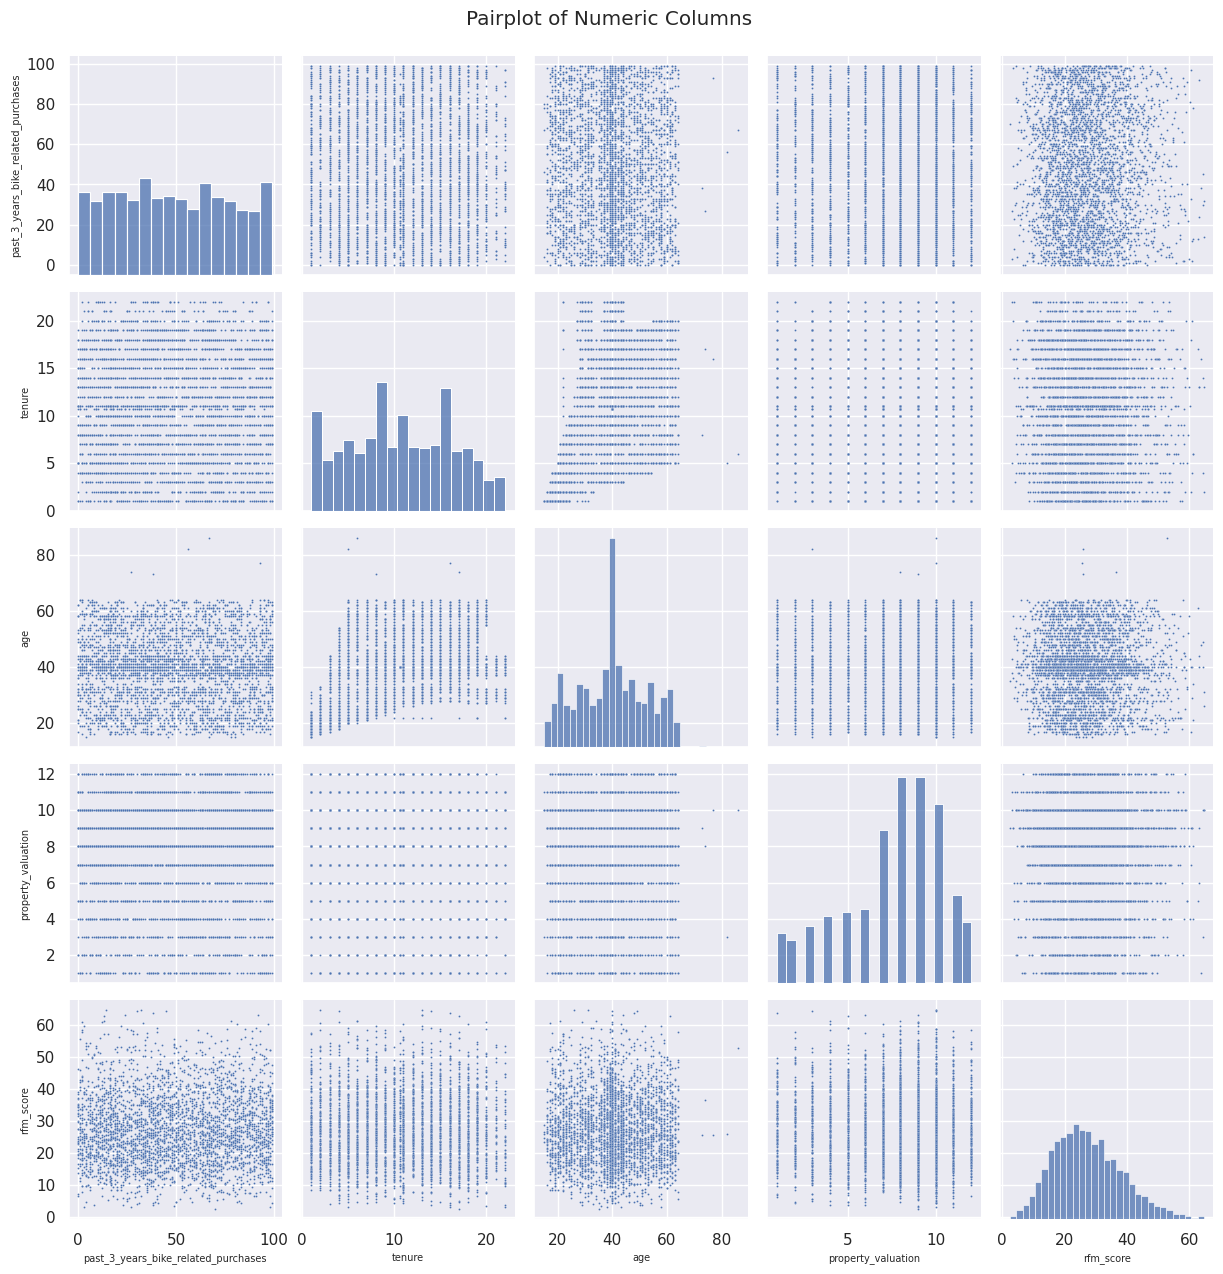

In [ ]:
sns.set(rc={'figure.figsize':(70, 70), 'axes.labelsize':7})
sns.pairplot(df_existing_customer, plot_kws={'s':2})

plt.suptitle('Pairplot of Numeric Columns', y=1.02)


Visualize the categorical columns.

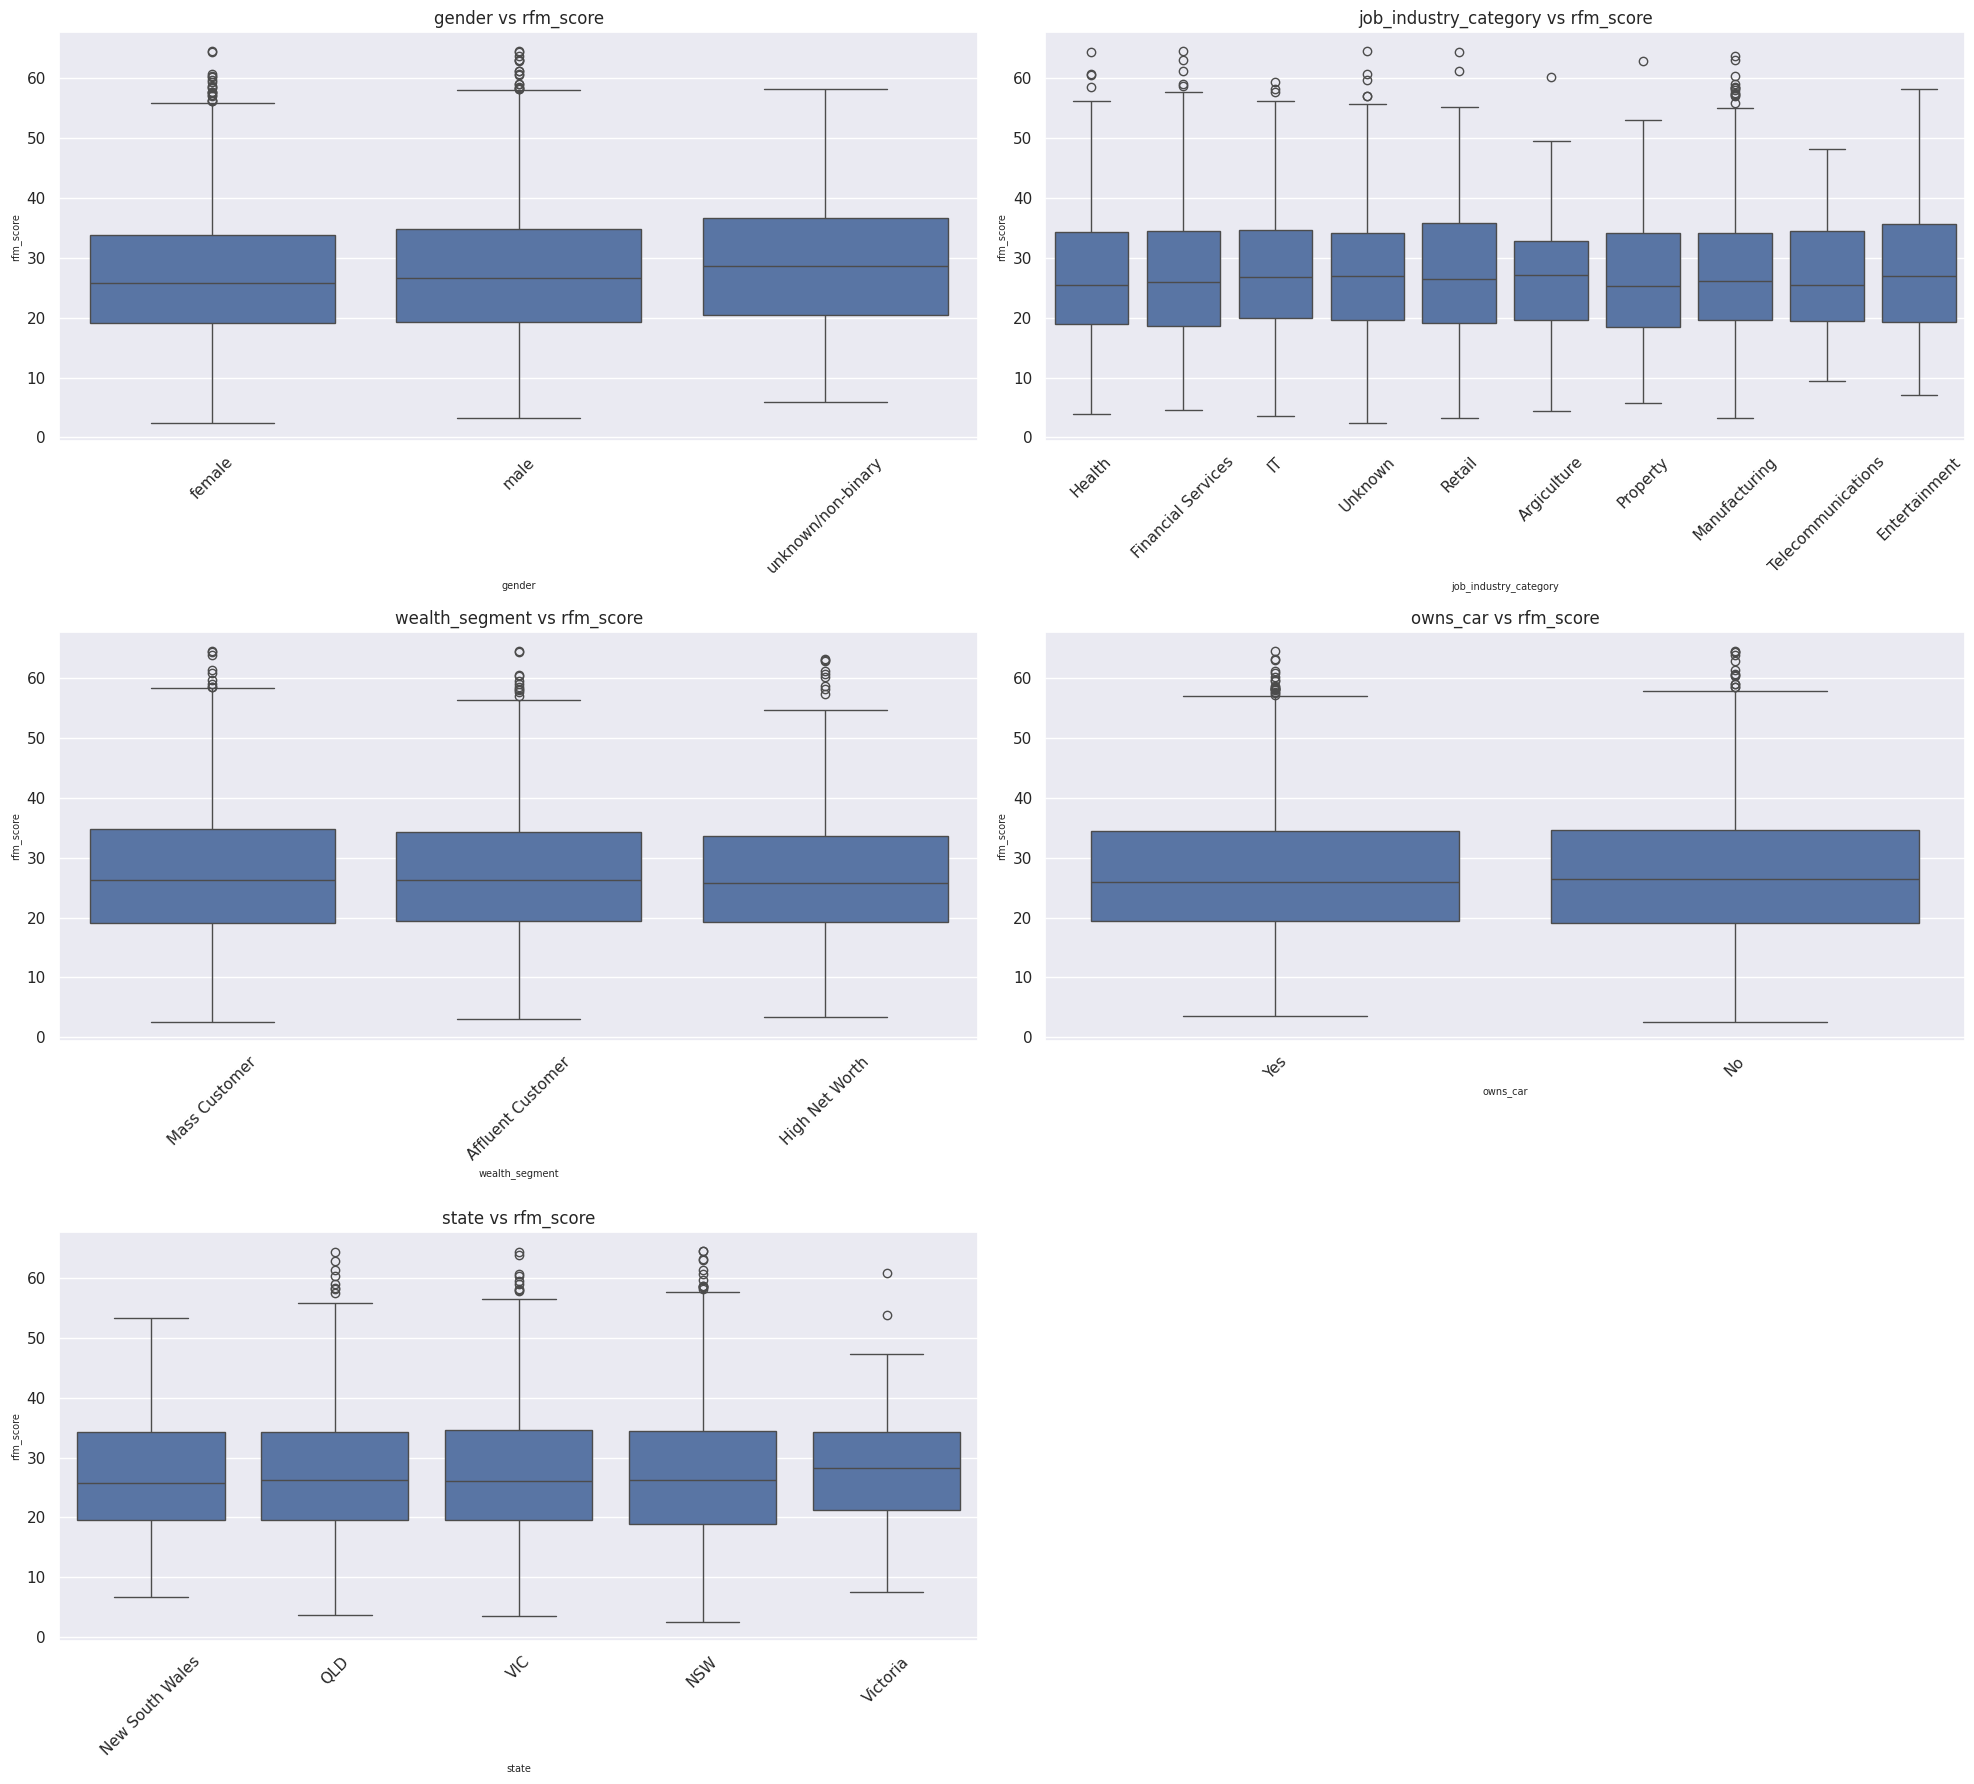

In [ ]:
categorical_columns = df_existing_customer.select_dtypes(include=['object', 'category']).columns
target_column = 'rfm_score'
num_cols = 2
num_rows = -(-len(categorical_columns) // num_cols)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 6*num_rows), squeeze=False)

for i, col in enumerate(categorical_columns):
  row, col_index = divmod(i, num_cols)
  sns.boxplot(data=df_existing_customer, x=col, y=target_column, ax=axes[row, col_index])
  axes[row, col_index].set_title(f'{col} vs rfm_score')
  axes[row, col_index].tick_params(axis='x', rotation=45)

for j in range(len(categorical_columns), num_rows*num_cols):
  fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

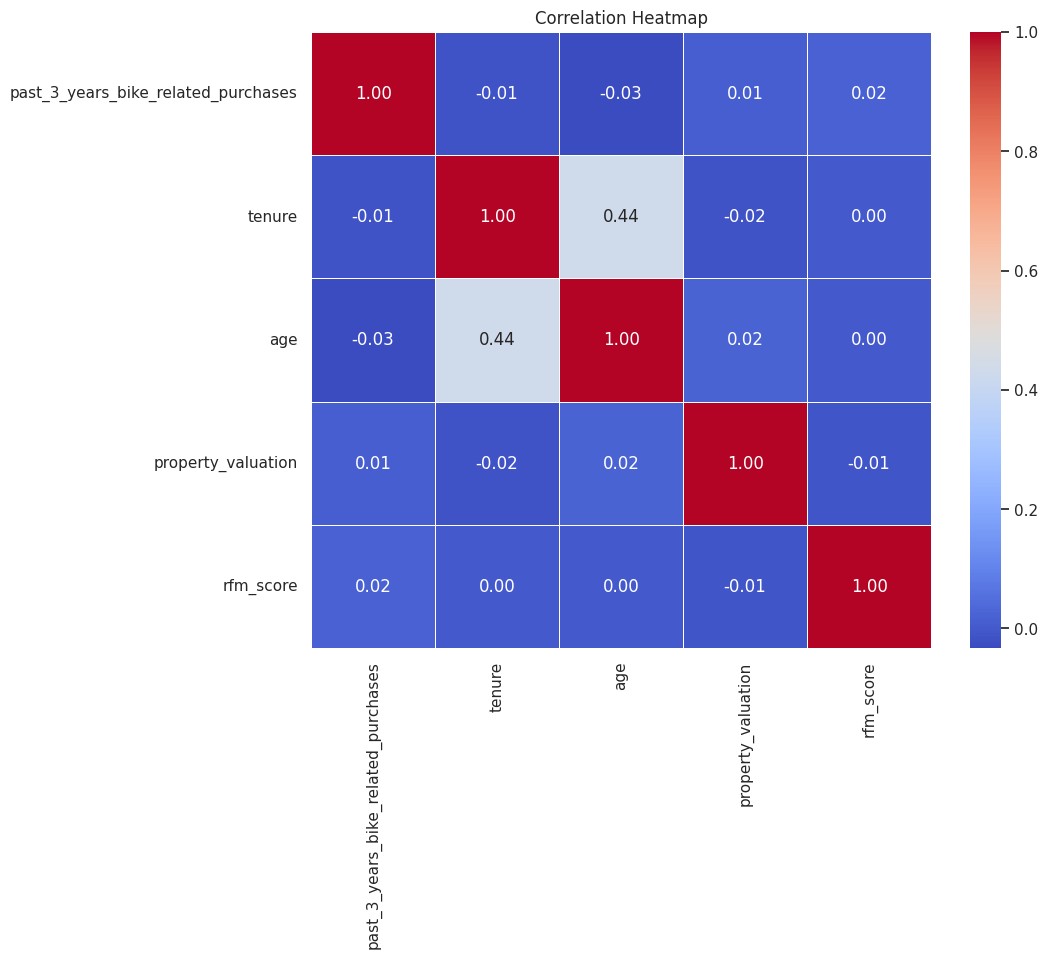

In [ ]:
numeric_columns = ['past_3_years_bike_related_purchases', 'tenure', 'age', 'property_valuation', 'rfm_score']

correlation_matrix = df_existing_customer[numeric_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
df_existing_customer.columns

Index(['gender', 'past_3_years_bike_related_purchases',
       'job_industry_category', 'wealth_segment', 'owns_car', 'tenure', 'age',
       'state', 'property_valuation', 'rfm_score'],
      dtype='object')

Train machine learning models to predict RFM scores. The models used are random forest, svm, linear regression, decision trees. Cross validation and hyperparameter tuning are performed.

In [ ]:
features = ['gender', 'past_3_years_bike_related_purchases', 'job_industry_category', 'wealth_segment',
            'owns_car', 'tenure', 'age', 'state', 'property_valuation']
target = 'rfm_score'

X = df_existing_customer[features]
y = df_existing_customer[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)


In [ ]:
categorical_features = ['gender', 'job_industry_category', 'wealth_segment', 'state', 'owns_car']
numerical_features = ['past_3_years_bike_related_purchases', 'tenure', 'age', 'property_valuation']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ])

In [ ]:
models = {
    'randomforest': RandomForestRegressor(),
    # 'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=12),
    'decisiontree': DecisionTreeRegressor(random_state=12),
    'ridge': Ridge(),
    'svr': SVR(kernel='rbf')
}

param_grids = {
    'randomforest': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [5, 10, None],
        'model__min_samples_split': [2, 5],
    },
    'decisiontree': {
        'model__max_depth': [5, 10, None],
        'model__min_samples_split':[2,5],
    },
    'ridge':{
        'model__alpha':[0.1, 1.0, 10.0]
    },
    'svr':{
        'model__C': [0.1, 1.0, 10.0],
        'model__gamma': ['scale', 'auto'],
        'model__epsilon': [0.1, 0.2]
    }
}

best_models = {}

for model_name, model in models.items():
  pipeline = Pipeline(steps=[
      ('preprocessor', preprocessor),
      ('model', model)])

  scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
  print(f"{model_name} cross-validation RMSE scores: {-scores.mean()}")

  grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=5, scoring='neg_root_mean_squared_error')
  grid_search.fit(X_train, y_train)

  best_models[model_name] = grid_search.best_estimator_
  print(f"Best parameters for {model_name}: {grid_search.best_params_}")

for model_name, model in best_models.items():
  y_pred = model.predict(X_test)
  rmse = root_mean_squared_error(y_test, y_pred)
  print(f"{model_name} test RMSE: {rmse}")

for model_name in ['randomforest', 'decisiontree', 'svr', 'ridge']:
  if model_name in best_models:
    model = best_models[model_name]
    if hasattr(model, 'feature_importances_'):
      importances = model.named_steps[model_name].feature_importances_
      print(f"Feature importances for {model_name}: {importances}")

randomforest cross-validation RMSE scores: 11.499097006879843
Best parameters for randomforest: {'model__max_depth': 5, 'model__min_samples_split': 2, 'model__n_estimators': 200}
decisiontree cross-validation RMSE scores: 16.10708445538832
Best parameters for decisiontree: {'model__max_depth': 5, 'model__min_samples_split': 5}
ridge cross-validation RMSE scores: 11.192870521125474
Best parameters for ridge: {'model__alpha': 10.0}
svr cross-validation RMSE scores: 11.278151726558871
Best parameters for svr: {'model__C': 0.1, 'model__epsilon': 0.2, 'model__gamma': 'auto'}
randomforest test RMSE: 10.798999112736025
decisiontree test RMSE: 10.935541819218606
ridge test RMSE: 10.795975471678444
svr test RMSE: 10.870038924503135


In [ ]:
df_existing_customer['rfm_score'].describe()

,rfm_score
count,3476.000000
mean,27.361360
std,11.041493
min,2.478364
25%,19.211873
50%,26.246562
75%,34.509766
max,64.578694


In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 696 entries, 3343 to 366
Data columns (total 9 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   gender                               696 non-null    object 
 1   past_3_years_bike_related_purchases  696 non-null    int64  
 2   job_industry_category                696 non-null    object 
 3   wealth_segment                       696 non-null    object 
 4   owns_car                             696 non-null    object 
 5   tenure                               696 non-null    float64
 6   age                                  696 non-null    int64  
 7   state                                696 non-null    object 
 8   property_valuation                   696 non-null    int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 54.4+ KB


In [ ]:
df_rfm2 = df_rfm_copy.drop(columns=('rfm_score'))
df_rfm2['recency'] = df_rfm2['recency'] * 10000
df_rfm2['frequency'] = df_rfm2['frequency'] * 10000
df_rfm2['monetary'] = df_rfm2['monetary'] * 10000
df_rfm2.head()

,recency,frequency,monetary,customer_id
0,198.300283,7692.307692,2576.834991,1
1,3626.062323,1538.461538,1897.378296,2
2,2889.518414,5384.615385,2872.633726,3
3,5524.079320,769.230769,176.327692,4
4,453.257790,3846.153846,2042.119914,5


In [ ]:
fig = px.scatter_3d(
    df_rfm2,
    x='recency',
    y='frequency',
    z='monetary',
    color='monetary',
    size='monetary',
    labels={
        'recency': 'Recency',
        'frequenncy': 'Frequency',
        'monetary': 'Monetary'
    },
    title="Recency, Frequency, Monetary"
)

fig.update_traces(marker=dict(opacity=0.8))
fig.update_layout(
    scene=dict(
        xaxis_title='Recency',
        yaxis_title='Frequency',
        zaxis_title='Monetary'
    ),
    coloraxis_colorbar=dict(title='Monetary')
)

fig.show()

Train XGBoost model.

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(random_state=12))
])

param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [3, 4, 5],
    'regressor__learning_rate': [0.01, 0.1],
    'regressor__min_child_weight': [1, 3],
    'regressor__subsample': [0.8, 0.9],
    'regressor__colsample_bytree': [0.8, 0.9]
}

def train_and_evaluate_model(X, y, test_size=0.2, random_state=12):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

  grid_search = GridSearchCV(
      model,
      param_grid,
      cv=5,
      scoring='neg_root_mean_squared_error',
      n_jobs=-1,
      verbose=1
  )

  grid_search.fit(X_train, y_train)

  print('Best parameters:', grid_search.best_params_)

  best_model = grid_search.best_estimator_

  cv = KFold(n_splits=5, shuffle=True, random_state=random_state)
  cv_scores = cross_val_score(
      best_model,
      X_train,
      y_train,
      scoring='neg_root_mean_squared_error',
      cv=cv,
      n_jobs=-1
  )

  cv_scores = -cv_scores

  print('\nCross-validation RMSE scores:', cv_scores)
  print('Mean CV RMSE: {:.4f}(+/-{:.4f})'.format(cv_scores.mean(), cv_scores.std()*2))

  y_pred = best_model.predict(X_test)
  test_rmse = root_mean_squared_error(y_test, y_pred)
  print("\nTest set RMSE: {:.4f}".format(test_rmse))

  return best_model, test_rmse

X = df_existing_customer[features]
y = df_existing_customer[target]

best_model, test_rmse = train_and_evaluate_model(X, y)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best parameters: {'regressor__colsample_bytree': 0.8, 'regressor__learning_rate': 0.01, 'regressor__max_depth': 3, 'regressor__min_child_weight': 1, 'regressor__n_estimators': 100, 'regressor__subsample': 0.8}

Cross-validation RMSE scores: [11.37739897 11.16523688 11.22072742 10.9958631  10.91394191]
Mean CV RMSE: 11.1346(+/-0.3289)

Test set RMSE: 10.7773


Based on model performance evaluation, the best model is XGBoost, eventhough the performance is not good. After this we will predict RFM score on new customers data.

Process the new customers data.

In [ ]:
# df_new_customer.head()

,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,...,state,country,property_valuation,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Rank,Value
0,Chickie,Brister,Male,86,1957-07-12,General Manager,Manufacturing,Mass Customer,N,Yes,...,QLD,Australia,6,0.56,0.7000,0.8750,0.743750,1,1,1.718750
1,Morly,Genery,Male,69,1970-03-22,Structural Engineer,Property,Mass Customer,N,No,...,NSW,Australia,11,0.89,0.8900,1.1125,0.945625,1,1,1.718750
2,Ardelis,Forrester,Female,10,1974-08-28 00:00:00,Senior Cost Accountant,Financial Services,Affluent Customer,N,No,...,VIC,Australia,5,1.01,1.0100,1.0100,1.010000,1,1,1.718750
3,Lucine,Stutt,Female,64,1979-01-28,Account Representative III,Manufacturing,Affluent Customer,N,Yes,...,QLD,Australia,1,0.87,1.0875,1.0875,1.087500,4,4,1.703125
4,Melinda,Hadlee,Female,34,1965-09-21,Financial Analyst,Financial Services,Affluent Customer,N,No,...,NSW,Australia,9,0.52,0.5200,0.6500,0.650000,4,4,1.703125


In [ ]:
# df_existing_customer.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3476 entries, 0 to 3485
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   gender                               3476 non-null   object 
 1   past_3_years_bike_related_purchases  3476 non-null   int64  
 2   job_industry_category                3476 non-null   object 
 3   wealth_segment                       3476 non-null   object 
 4   owns_car                             3476 non-null   object 
 5   tenure                               3476 non-null   float64
 6   age                                  3476 non-null   int64  
 7   state                                3476 non-null   object 
 8   property_valuation                   3476 non-null   int64  
 9   rfm_score                            3476 non-null   float64
dtypes: float64(2), int64(3), object(5)
memory usage: 298.7+ KB


Copy the new customer data from the first copy in case it has been tampered with.

In [ ]:
df_new_customer = df_new_customer_copy
# df_new_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   first_name                           1000 non-null   object 
 1   last_name                            971 non-null    object 
 2   gender                               1000 non-null   object 
 3   past_3_years_bike_related_purchases  1000 non-null   int64  
 4   DOB                                  983 non-null    object 
 5   job_title                            894 non-null    object 
 6   job_industry_category                835 non-null    object 
 7   wealth_segment                       1000 non-null   object 
 8   deceased_indicator                   1000 non-null   object 
 9   owns_car                             1000 non-null   object 
 10  tenure                               1000 non-null   int64  
 11  address                        

Create ID column.

In [ ]:
df_new_customer['new_customer_id'] = range(1, len(df_new_customer) + 1)
df_new_customer['new_customer_id'] = df_new_customer['new_customer_id'].astype('str')

Delete unused columns.

In [ ]:
df_new_customer = df_new_customer.drop(columns=['job_title', 'address', 'Unnamed: 16', 'Unnamed: 17',
                                                'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Rank', 'Value',
                                                'postcode', 'address', 'country'])
# df_new_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   first_name                           1000 non-null   object
 1   last_name                            971 non-null    object
 2   gender                               1000 non-null   object
 3   past_3_years_bike_related_purchases  1000 non-null   int64 
 4   DOB                                  983 non-null    object
 5   job_industry_category                835 non-null    object
 6   wealth_segment                       1000 non-null   object
 7   deceased_indicator                   1000 non-null   object
 8   owns_car                             1000 non-null   object
 9   tenure                               1000 non-null   int64 
 10  state                                1000 non-null   object
 11  property_valuation                   1000 no

Remove customers who have passed away (if any).

In [ ]:
# df_new_customer['deceased_indicator'].unique()
df_new_customer = df_new_customer.drop(columns=['deceased_indicator'])

Fix the age column.

In [ ]:
df_new_customer['age'] = (reference_date - pd.to_datetime(df_new_customer['DOB'])).dt.days / 365
df_new_customer['age'] = df_new_customer['age'].fillna(df_new_customer['age'].mean())
df_new_customer['age'] = df_new_customer['age'].astype(int)
df_new_customer = df_new_customer[df_new_customer['age'] <= 90]
df_new_customer = df_new_customer.drop(columns=['DOB'])
# df_new_customer.info()

Drop rows with null values in job industry category column.

In [ ]:
df_new_customer = df_new_customer.dropna(subset=['job_industry_category'])
# df_new_customer.info()

<class 'pandas.core.frame.DataFrame'>
Index: 835 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   first_name                           835 non-null    object
 1   last_name                            812 non-null    object
 2   gender                               835 non-null    object
 3   past_3_years_bike_related_purchases  835 non-null    int64 
 4   job_industry_category                835 non-null    object
 5   wealth_segment                       835 non-null    object
 6   owns_car                             835 non-null    object
 7   tenure                               835 non-null    int64 
 8   state                                835 non-null    object
 9   property_valuation                   835 non-null    int64 
 10  new_customer_id                      835 non-null    object
 11  age                                  835 non-null 

Fix the gender column.

In [ ]:
gender_mapping = {
    'F': 'female',
    'M': 'male',
    'Femal': 'female',
    'Male': 'male',
    'Female': 'female',
    'U': 'unknown/non-binary'
}

df_new_customer['gender'] = df_new_customer['gender'].map(gender_mapping)
print(df_new_customer['gender'].value_counts())

gender
female                428
male                  390
unknown/non-binary     17
Name: count, dtype: int64


Copy the processed new customer table for prediction.

In [ ]:
df_new_customer2 = df_new_customer.copy()
df_new_customer2 = df_new_customer2.drop(columns=['new_customer_id', 'first_name', 'last_name'])
df_new_customer2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 835 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   gender                               835 non-null    object
 1   past_3_years_bike_related_purchases  835 non-null    int64 
 2   job_industry_category                835 non-null    object
 3   wealth_segment                       835 non-null    object
 4   owns_car                             835 non-null    object
 5   tenure                               835 non-null    int64 
 6   state                                835 non-null    object
 7   property_valuation                   835 non-null    int64 
 8   age                                  835 non-null    int64 
dtypes: int64(4), object(5)
memory usage: 65.2+ KB


Visualize the new customer data in case there is something wrong with it.

Text(0.5, 1.02, 'Pairplot of Numeric Columns')

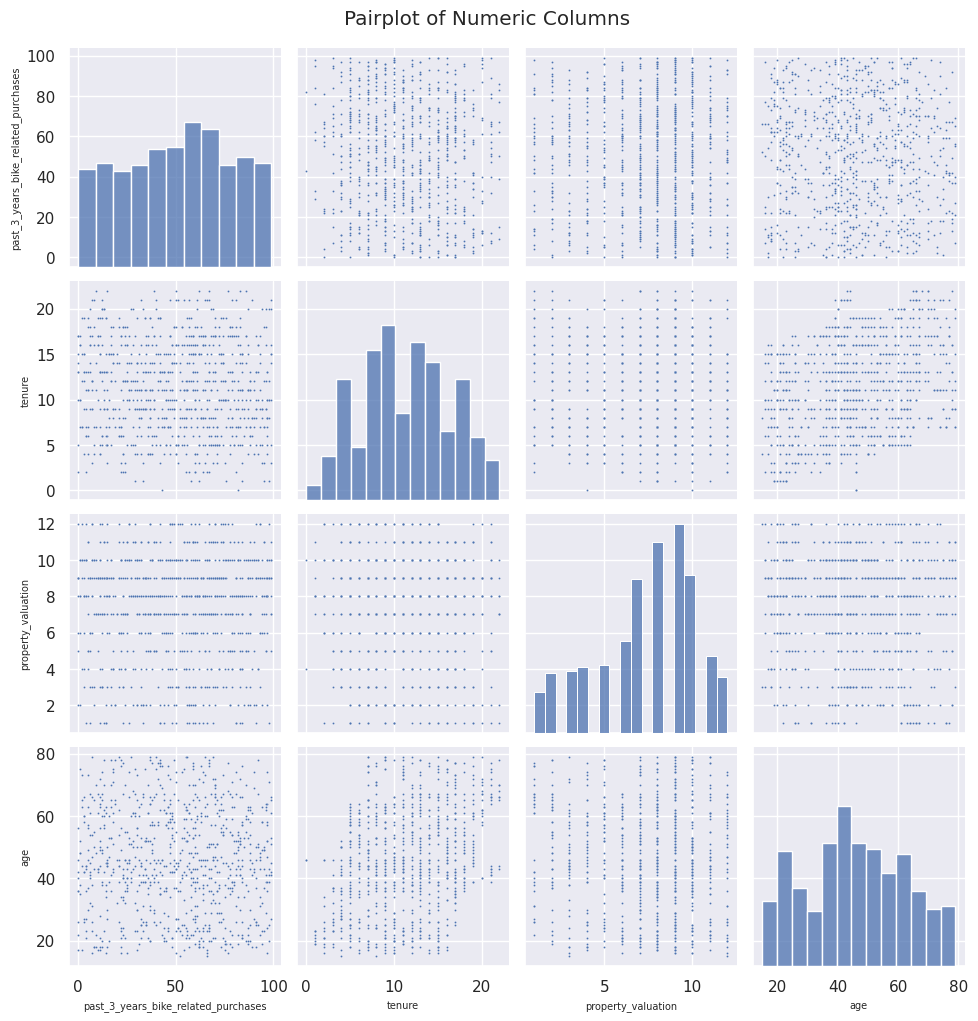

In [ ]:
sns.set(rc={'figure.figsize':(70, 70), 'axes.labelsize':7})
sns.pairplot(df_new_customer2, plot_kws={'s':2})

plt.suptitle('Pairplot of Numeric Columns', y=1.02)


In [ ]:
# df_new_customer2.columns

Index(['gender', 'past_3_years_bike_related_purchases',
       'job_industry_category', 'wealth_segment', 'owns_car', 'tenure',
       'state', 'property_valuation', 'age'],
      dtype='object')

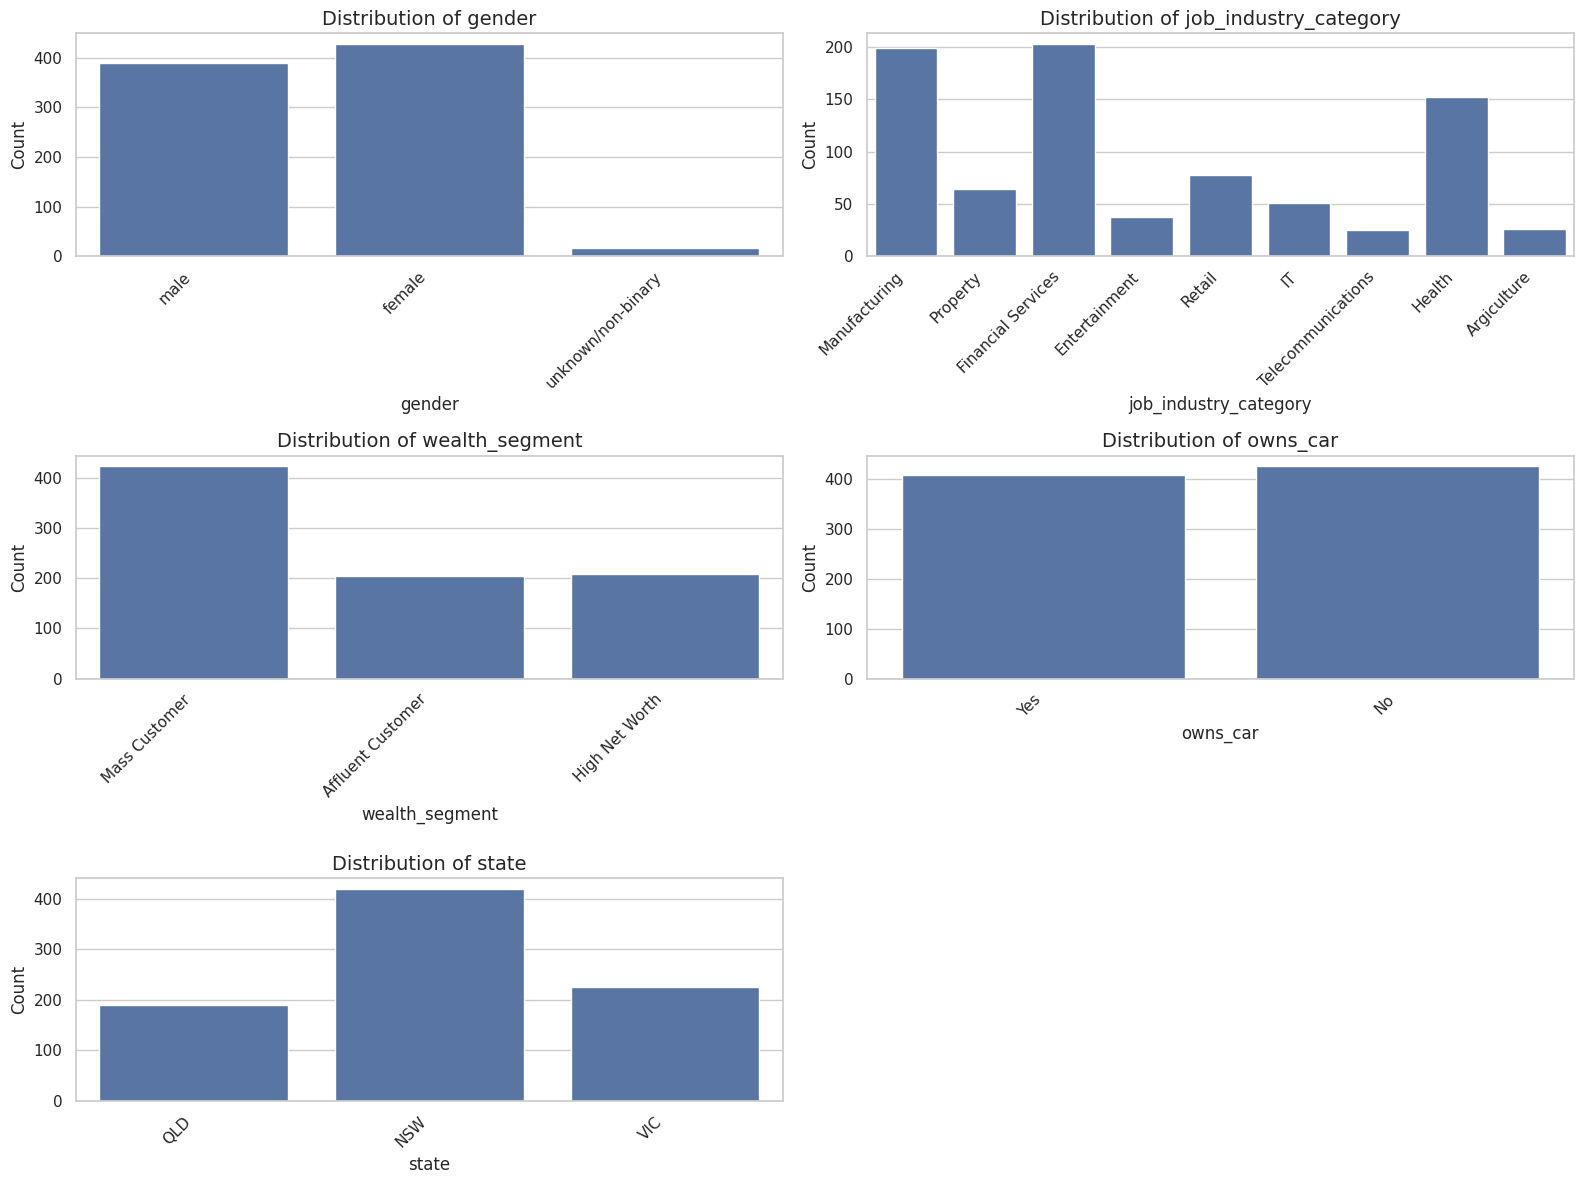

In [ ]:
categorical_columns = ['gender', 'job_industry_category', 'wealth_segment', 'owns_car', 'state']
sns.set(style='whitegrid')

plt.figure(figsize=(16, 12))

for i, column in enumerate(categorical_columns, 1):
  plt.subplot(3, 2, i)
  sns.countplot(data=df_new_customer2, x=column)
  plt.title(f"Distribution of {column}", fontsize=14)
  plt.xticks(rotation=45, ha='right')
  plt.xlabel(column, fontsize=12)
  plt.ylabel('Count', fontsize=12)

plt.tight_layout()
plt.show()

Generate RFM predictions for the new customer data using the XGBoost best model.

In [ ]:
rfm_prediction = best_model.predict(df_new_customer2)
# rfm_prediction

array([27.458664, 26.940203, 27.474377, 26.983526, 27.229378, 31.528427,
       27.072416, 27.321693, 26.98065 , 27.415989, 27.430464, 27.25094 ,
       27.249325, 26.940895, 27.226702, 27.20035 , 26.99676 , 27.385866,
       31.154877, 26.519674, 27.239872, 27.248178, 27.438545, 32.531986,
       31.414698, 26.754517, 27.804089, 27.292559, 27.163818, 30.758062,
       27.498333, 27.270536, 27.23195 , 27.26415 , 26.852417, 27.149601,
       30.510826, 26.93255 , 27.594776, 26.954277, 27.279291, 27.254765,
       32.986866, 27.23037 , 26.971563, 27.15805 , 27.291399, 28.13396 ,
       27.22364 , 27.540821, 27.605762, 27.229506, 27.116077, 31.756947,
       26.853731, 26.880663, 27.696201, 27.173613, 27.255718, 26.83053 ,
       27.552124, 27.533817, 27.213675, 27.814016, 27.605742, 27.61573 ,
       27.177101, 27.059233, 27.013538, 28.012745, 27.134933, 27.016405,
       27.34462 , 27.22663 , 27.151682, 31.810068, 27.03661 , 27.305246,
       27.549433, 27.726439, 31.312832, 27.59778 , 

Merge the prediction results to the new customers data.

In [ ]:
df_new_customer['rfm_prediction'] = rfm_prediction
df_new_customer.head()

,first_name,last_name,gender,past_3_years_bike_related_purchases,job_industry_category,wealth_segment,owns_car,tenure,state,property_valuation,new_customer_id,age,rfm_prediction
0,Chickie,Brister,male,86,Manufacturing,Mass Customer,Yes,14,QLD,6,1,60,27.458664
1,Morly,Genery,male,69,Property,Mass Customer,No,16,NSW,11,2,47,26.940203
2,Ardelis,Forrester,female,10,Financial Services,Affluent Customer,No,10,VIC,5,3,43,27.474377
3,Lucine,Stutt,female,64,Manufacturing,Affluent Customer,Yes,5,QLD,1,4,38,26.983526
4,Melinda,Hadlee,female,34,Financial Services,Affluent Customer,No,19,NSW,9,5,52,27.229378


In [ ]:
# df_new_customer.info()

<class 'pandas.core.frame.DataFrame'>
Index: 835 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   first_name                           835 non-null    object 
 1   last_name                            812 non-null    object 
 2   gender                               835 non-null    object 
 3   past_3_years_bike_related_purchases  835 non-null    int64  
 4   job_industry_category                835 non-null    object 
 5   wealth_segment                       835 non-null    object 
 6   owns_car                             835 non-null    object 
 7   tenure                               835 non-null    int64  
 8   state                                835 non-null    object 
 9   property_valuation                   835 non-null    int64  
 10  new_customer_id                      835 non-null    object 
 11  age                                  

Reorder the column position

In [ ]:
column_order = ['new_customer_id', 'first_name', 'last_name', 'rfm_prediction', 'gender',
                'age', 'past_3_years_bike_related_purchases', 'job_industry_category',
                'wealth_segment', 'owns_car', 'tenure', 'state', 'property_valuation']
df_new_customer = df_new_customer[column_order]

In [ ]:
df_new_customer = df_new_customer.sort_values(by='rfm_prediction', ascending=False)

Visualize the distribution of the RFM prediction.

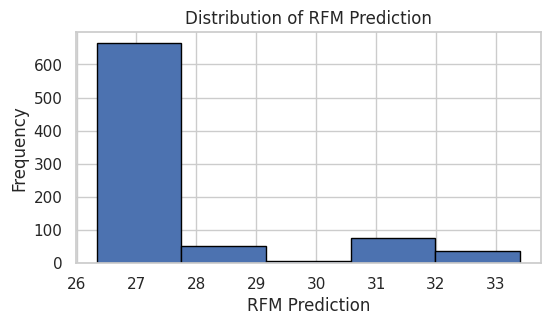

In [ ]:
df_new_customer['rfm_prediction'].plot.hist(bins=5, edgecolor='black', figsize=(6,3))
plt.title('Distribution of RFM Prediction')
plt.xlabel('RFM Prediction')
plt.ylabel('Frequency')
plt.show()

Based on the prediction distribution, we decide the cut off score to be 31. So the priority customers are the ones whose RFM predictions are 31 or above.

In [ ]:
priority_customer = df_new_customer[df_new_customer['rfm_prediction'] >= 31]
priority_customer

,new_customer_id,first_name,last_name,rfm_prediction,gender,age,past_3_years_bike_related_purchases,job_industry_category,wealth_segment,owns_car,tenure,state,property_valuation
299,300,Tiphanie,Blackader,33.398129,female,70,59,Retail,Mass Customer,No,17,NSW,11
416,417,Dennis,Varnham,33.183910,male,64,57,Entertainment,Affluent Customer,No,17,VIC,3
393,394,Packston,Wackett,33.068050,male,67,10,Financial Services,Mass Customer,No,19,VIC,9
49,50,Thaxter,Kingsbury,32.986866,male,67,12,Argiculture,Mass Customer,No,20,NSW,12
458,459,Marcellina,Baynton,32.857502,female,70,60,Financial Services,Mass Customer,No,16,VIC,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,236,Rolland,Esmead,31.093067,male,77,41,Health,Affluent Customer,No,8,NSW,8
872,873,Marie-jeanne,Breawood,31.074648,female,64,37,Health,High Net Worth,No,8,NSW,6
612,613,Nev,Prosh,31.050755,male,67,29,Health,Affluent Customer,Yes,17,NSW,8
263,264,Zondra,Ringham,31.039246,female,70,36,Financial Services,Mass Customer,Yes,7,QLD,5
